In [352]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
import scipy.stats.qmc as qmc

In [354]:
nmesh=50

In [355]:
latent_sampler = qmc.LatinHypercube(d=2)
latent_sample = latent_sampler.random(n=nmesh)

In [356]:
l_bounds = [-5,-1]
u_bounds = [5,1]
latent = qmc.scale(latent_sample, l_bounds, u_bounds)

In [357]:
theta_sampler = qmc.LatinHypercube(d=1)
theta_sample = theta_sampler.random(n=30)

l_bounds = [-5]
u_bounds = [5]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [358]:
def fun(x,a,b,c):
    quad=-a*np.sin(x-c)+b
    return quad

In [359]:
nsamp=20
inputs = []
outputs = []
for i,l in enumerate(latent):
    theta_sample = theta_sampler.random(n=nsamp)
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)
    outputs.append(fun(theta,1,l[0],l[1]))

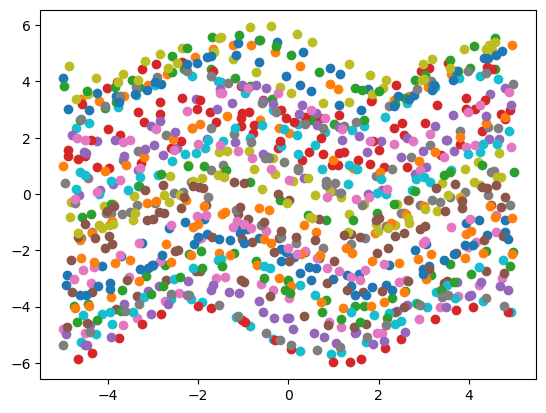

In [360]:
for i,j in enumerate(inputs):
    plt.plot(inputs[i],outputs[i],'o')

In [361]:
R2_mean = np.zeros((1,len(inputs)) )
R2_std = np.zeros((1,len(inputs))) 
emulators=[]
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean,std=emulator.R2_sample(X_test,y_test,100)
    emulators.append(emulator)
    R2_mean[:,i]=mean
    R2_std[:,i]=std

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [362]:
R2_mean

array([[0.99719346, 0.99933273, 0.9998188 , 0.99709129, 0.99984092,
        0.9996739 , 0.9998436 , 0.95914209, 0.99984252, 0.99987906,
        0.99935502, 0.99851561, 0.99742997, 0.99211365, 0.9993245 ,
        0.99946952, 0.99989641, 0.9905709 , 0.99959862, 0.99927688,
        0.99990976, 0.99986053, 0.99989259, 0.99985141, 0.99973547,
        0.74193567, 0.99987394, 0.99886668, 0.99866426, 0.99966812,
        0.99984276, 0.99961668, 0.99855578, 0.999273  , 0.99883634,
        0.99959898, 0.99887991, 0.99854487, 0.99960297, 0.9993093 ,
        0.99975556, 0.9990651 , 0.99979711, 0.99733084, 0.99507523,
        0.99975115, 0.99987352, 0.99942309, 0.99962729, 0.99973243]])

In [363]:
nmesh2=nmesh-1

In [364]:
latent.shape

(50, 2)

In [365]:
modeweights1 = np.repeat(latent[0:(nmesh2)],nsamp,axis=0)

In [366]:
modeweights1

array([[-1.88189686, -0.21941708],
       [-1.88189686, -0.21941708],
       [-1.88189686, -0.21941708],
       ...,
       [ 4.97360617,  0.98254543],
       [ 4.97360617,  0.98254543],
       [ 4.97360617,  0.98254543]])

In [367]:
large_input = np.array(inputs[0:(nmesh2)]).reshape((nmesh2)*nsamp,1)

In [368]:
large_input = np.concatenate((large_input,modeweights1),axis=1)

In [369]:
large_output = np.array(outputs[0:(nmesh2)]).reshape((nmesh2)*nsamp,1)

In [370]:
large_input.shape

(980, 3)

In [371]:
# split original dataset in training, validation and testing sets
X=torch.tensor(large_input)
y=torch.tensor(large_output)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=50,
    random_state=seed
)

emulator=GPE.ensemble(X_train,y_train,mean_func='linear')

emulator.R2(X_test,y_test)

0


tensor([0.9998], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [372]:
inputs[nmesh2]

array([[-0.10246893],
       [ 0.59281966],
       [ 0.19152728],
       [-4.49835335],
       [-3.28288791],
       [ 3.00651724],
       [ 4.31814955],
       [ 1.34230391],
       [-3.91471823],
       [ 4.89205111],
       [-4.62002282],
       [ 2.05277067],
       [-1.17883869],
       [-2.57037692],
       [-1.78677096],
       [ 1.52254372],
       [ 3.98702883],
       [-2.29158076],
       [ 2.8275908 ],
       [-0.57571719]])

In [373]:
np.repeat(latent[[nmesh2]],nsamp,axis=0)

array([[1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794],
       [1.46901302, 0.88196794]])

In [374]:
latent[nmesh2]

array([1.46901302, 0.88196794])

In [375]:
leftout_input = np.concatenate((inputs[nmesh2],np.repeat(latent[[nmesh2]],nsamp,axis=0)),axis=1)

In [376]:
emulator.R2(torch.tensor(leftout_input),torch.tensor(outputs[nmesh-1]))

tensor([0.9900], dtype=torch.float64, grad_fn=<RsubBackward1>)

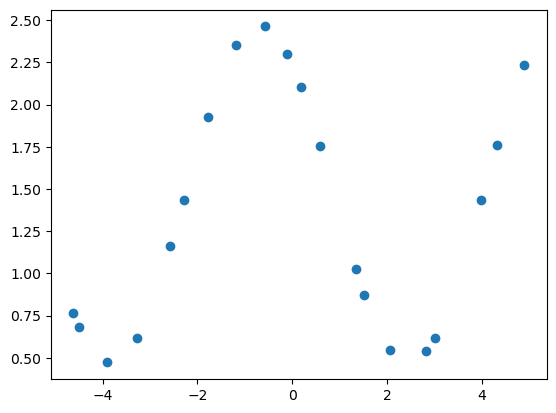

In [377]:
plt.plot(inputs[nmesh-1],outputs[nmesh-1],'o')

In [378]:
i=0
j=0
t_size=4
inputs2 = inputs.copy()
inputs2.pop(i)
outputs2 = outputs.copy()
outputs2.pop(i)
emulators2 = emulators.copy()
emulators2.pop(i)

inputData_1 = inputs2[j]
outputData_1 = outputs2[j]

X1 = torch.tensor(inputData_1)
Y1 = torch.tensor(outputData_1)
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

In [379]:
a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
delta_1 = GPE.ensemble(X_train[a,:],y_train[a,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)

0


In [380]:
delta_1.R2(X_test,y_test).detach().numpy()

array([0.34197838])